<font size="8"> **Accessing sea surface temperature data from NOAA** </font>  
This notebook access the [NOAA $1/4^{\circ}$ Daily Optimum Interpolation Sea Surface Temperature (OISST)](https://www.ncei.noaa.gov/products/optimum-interpolation-sst) (version 2.1) dataset available in Gadi.  

The SST data is then regridded to match ACCESS-OM2-01 model outputs.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading relevant libraries

In [2]:
#Loading and manipulating data
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import re
from glob import glob
from dask.distributed import Client
import rioxarray
import xesmf as xe

#Analysis module
import UsefulFunctions as uf

#Packages for plotting
import matplotlib.pyplot as plt

#Show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

## Parallelising work

In [3]:
client = Client()

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [4]:
#Defining location of OISST files in Gadi
varDict =  {'oisst': '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/*.nc',
            #Location of output data - SST monthly means
            'out_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/SSTObs'}

# Accessing sea surface temperature data from observations

In [5]:
#Get list of all OISST files - sort them alphabetically
oisst_files = sorted(glob(varDict['oisst']))

#Loading all files into a single dataset - Only SST data 
sst_obs = xr.open_mfdataset(oisst_files, parallel = True).sst

#Removing depth (zlev) dimension because it only contains a single depth bin
sst_obs = sst_obs.squeeze().drop('zlev')

#Selecting data for the Southern Ocean only
sst_obs = sst_obs.sel(lat = slice(-90, -40))

#Checking result
sst_obs

<xarray.DataArray 'sst' (time: 15361, lat: 200, lon: 1440)>
dask.array<getitem, shape=(15361, 200, 1440), dtype=float32, chunksize=(366, 200, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... -40.62 -40.38 -40.12
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2023-09-22T12:00:00
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius

# Calculating monthly means for SST
We will use mean monthly data to model the distribution of crabeater seals. Thus, we will calculate monthly means before storing the data to disk.

In [10]:
#Defining folder where monthly means will be saved
folder_out = os.path.join(varDict['out_folder'], 'monthly')
#Ensure folder exists
os.makedirs(folder_out, exist_ok = True)

#Loading each file - Calculate monthly means and save outputs
for yr, da in sst_obs.groupby('time.year'):
    #Calculate monthly mean
    da = da.groupby('time.month').mean()
    #Creating monthly date to be included in data array (mid-month)
    dates = [pd.to_datetime(f'{yr}-{m}-15') for m in da.month.values]
    #Renaming month dimension as time
    da = da.rename({'month': 'time'})
    #Using corrected dates
    da['time'] = dates
    #Saving outputs
    da.to_netcdf(os.path.join(folder_out, f'monthly_mean_sst_obs_{str(yr)}.nc'))

# Regridding data to match ACCESS-OM2-01 grid
We will use this data as input to model crabeater seals distribution. Then, we will compare the results of the estimated distribution based on observational environmental data to that of the model. We will regrid observations to match the model outputs grid to facilitate the comparison of crabeater disribution.

## Loading all monthly means for SIC observations

In [28]:
# Loading monthly SIC observations
sst_monthly_obs = xr.open_mfdataset(sorted(glob(os.path.join(varDict['out_folder'], 'monthly/*.nc')))).sst
#Adding land mask
sst_monthly_obs['mask'] = xr.where(~np.isnan(sst_monthly_obs), 1, 0).isel(time = 0).squeeze().drop('time')
sst_monthly_obs

<xarray.DataArray 'sst' (time: 505, lat: 200, lon: 1440)>
dask.array<concatenate, shape=(505, 200, 1440), dtype=float32, chunksize=(12, 200, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... -40.62 -40.38 -40.12
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-15 1981-10-15 ... 2023-09-15
    mask     (lat, lon) int64 dask.array<chunksize=(200, 1440), meta=np.ndarray>
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius

## Loading ACCESS-OM2-01 sample grid
This is the grid that we want the SIC observations to have after regridding is done.

In [18]:
#Creating new COSIMA cookbook session
session = cc.database.create_session()

#Accessing the area of grid and keeping data for the Southern Ocean only
grid = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1).sel(yt_ocean = slice(-90, -45))
#Correcting longitude values to keep them between +/- 180
grid = uf.corrlong(grid)
#Renaming coordinates to match observations
grid = grid.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
#Adding mask of land areas
grid['mask'] = xr.where(~np.isnan(grid), 1, 0)

#Checking results
grid

<xarray.DataArray 'area_t' (lat: 740, lon: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2022-04-27
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

## Regridding SST data

In [30]:
#We only need to calculate the regridder once - Note that we use the reprojected SIC data
reg_hr = xe.Regridder(sst_monthly_obs, grid, 'bilinear')

#Now we apply the regridder
reg_obs = reg_hr(sst_monthly_obs)

#Checking results
reg_obs

<xarray.DataArray (time: 505, lat: 740, lon: 3600)>
dask.array<_regrid, shape=(505, 740, 3600), dtype=float32, chunksize=(12, 740, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-15 1981-10-15 ... 2023-09-15
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -45.18 -45.11 -45.04
    mask     (lat, lon) int64 dask.array<chunksize=(540, 440), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

Rechunking data to match ACCESS-OM2-01, which will facilitate calculations. We will also add a variable name to the data array. We will also drop the land mask because it is no longer needed.

In [41]:
reg_obs = reg_obs.chunk((1, 540, 720))
reg_obs.name = 'SST_degC'
reg_obs = reg_obs.squeeze().drop('mask')
reg_obs

<xarray.DataArray 'SST_degC' (time: 505, lat: 740, lon: 3600)>
dask.array<rechunk-merge, shape=(505, 740, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-15 1981-10-15 ... 2023-09-15
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -45.18 -45.11 -45.04
Attributes:
    regrid_method:  bilinear

Plotting first time step of regridded data and comparing to original data ensure data has been correctly regridded. We set the minimum value to $-2^{\circ}C$ because water temperature should not be under $-1.8^{\circ}C$.

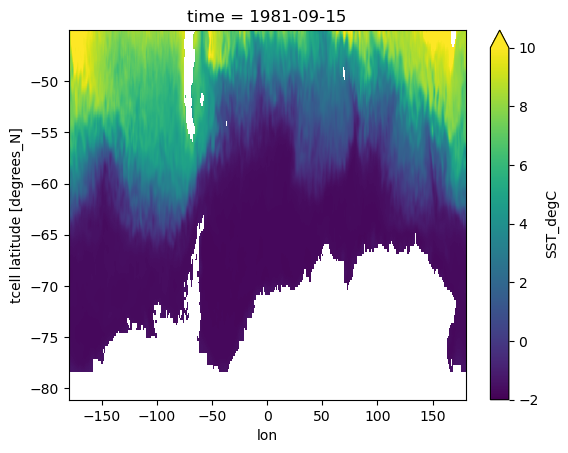

In [47]:
reg_obs.isel(time = 0).plot(vmin = -2, vmax = 10)

The original data goes to latitude $40^{\circ}S$, so we are subsetting the data to latitude $45^{\circ}S$ to match the area that was regridded.

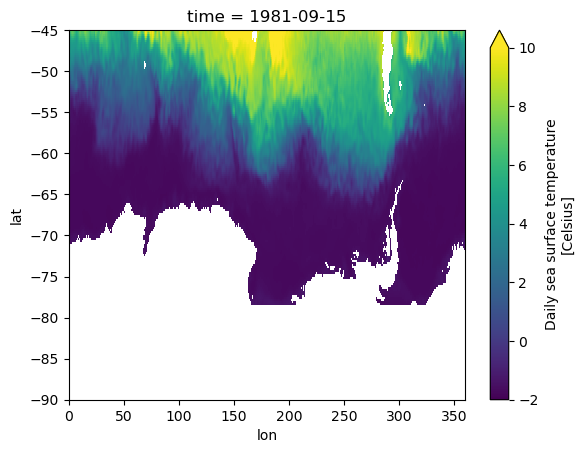

In [51]:
sst_monthly_obs.sel(lat = slice(-90, -45)).isel(time = 0).plot(vmin = -2, vmax = 10)

We will also calculate the maximum and minimum values of the original and regridded SST data to make sure the regridding did not result in large change to the range of temperature values.

In [50]:
print(sst_monthly_obs.sel(lat = slice(-90, -45)).min().values, sst_monthly_obs.sel(lat = slice(-90, -45)).max().values)

-1.8 20.491072


In [46]:
print(reg_obs.min().values, reg_obs.max().values)

-1.8 20.45978


The maximum temperature is $0.03^{\circ}C$ lower than the original data, but the minimum value is the same. The regridded data also appears to have been plotted correctly, so we can now save the results to disk.

# Saving masked regridded data to disk

In [43]:
#Defining folder where monthly means will be saved
folder_out = os.path.join(varDict['out_folder'], 'regridded_monthly')
#Ensure folder exists
os.makedirs(folder_out, exist_ok = True)

#Saving as yearly data
for yr in np.unique(reg_obs.time.dt.year):
    reg_obs.sel(time = str(yr)).to_netcdf(os.path.join(folder_out, f'regridded_SST_obs_{str(yr)}.nc'))